In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tensorflow.examples.tutorials.mnist import input_data

from edward.models import Normal, Bernoulli, Empirical
import edward as ed

In [22]:
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)
mb_size = 64
z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128
c = 0
lr = 1e-3

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [23]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [24]:
# =============================== Q(z|X) Encoder ======================================

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, reuse=True):
    with tf.variable_scope('encoder', reuse=reuse):
        h = tf.nn.relu(tf.matmul(X, Q_W1) + Q_b1)
        z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
        z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
        return z_mu, z_logvar

# =============================== Sampling Helper ======================================
def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

# =============================== P(X|z) Decoder ======================================

P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z, reuse=True):
    with tf.variable_scope('decoder', reuse=reuse):
        h = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
        logits = tf.matmul(h, P_W2) + P_b2
        prob = tf.nn.sigmoid(logits)
        return prob, logits



In [25]:
# =============================== DEFINE LOSS ====================================
X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample)

# Sampling from random z
X_samples, _ = P(z)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
# D_KL(Q(z|X) || P(z)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer().minimize(vae_loss)

# sess = tf.Session()
sess = ed.get_session() # need to make sure tf and edward share the global session
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

In [26]:
# =============================== TRAINING ====================================
i = 0
max_iter = 20000

for it in range(max_iter):
    X_mb, _ = mnist.train.next_batch(mb_size)

    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()

        samples = sess.run(X_samples, feed_dict={z: np.random.randn(16, z_dim)})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

Iter: 0
Loss: 795.6
()
Iter: 1000
Loss: 147.4
()
Iter: 2000
Loss: 124.8
()
Iter: 3000
Loss: 122.0
()
Iter: 4000
Loss: 115.7
()
Iter: 5000
Loss: 115.8
()
Iter: 6000
Loss: 119.9
()
Iter: 7000
Loss: 120.1
()
Iter: 8000
Loss: 114.8
()
Iter: 9000
Loss: 112.3
()
Iter: 10000
Loss: 108.0
()
Iter: 11000
Loss: 113.0
()
Iter: 12000
Loss: 108.3
()
Iter: 13000
Loss: 112.2
()
Iter: 14000
Loss: 112.3
()
Iter: 15000
Loss: 110.9
()
Iter: 16000
Loss: 107.4
()
Iter: 17000
Loss: 105.6
()
Iter: 18000
Loss: 110.9
()
Iter: 19000
Loss: 116.9
()


## Check that VAE can Reconstruct GT

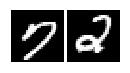

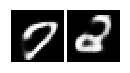

In [27]:
plt.close('all')
%matplotlib inline

num_checks = 2
x_gt, _ = mnist.train.next_batch(num_checks)
plot(x_gt)
plot(P(Q(x_gt)[0])[0].eval())
_ = 1 # prevent repeated plot in jupyter

In [28]:
def init_uninited_vars():
    unint_vars = []
    for var in tf.global_variables():
        if not tf.is_variable_initialized(var).eval():
            unint_vars.append(var)
    missingVarInit = tf.variables_initializer (unint_vars)
    sess.run(missingVarInit)

## HMC Inference

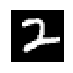

In [29]:
%matplotlib inline

inference_batch_size = 1
x_gt, _ = mnist.train.next_batch(inference_batch_size)
plot(x_gt)

T = 20000 # number of empirical samples in posterior
img_dim = 28
hmc_steps = T
leap_steps = 10
# print x_gt
# z = Normal(loc=tf.zeros([inference_batch_size, z_dim]), scale=tf.ones([inference_batch_size, z_dim])) # sample z
z = Normal(loc=Q(x_gt)[0], scale=tf.ones([inference_batch_size, z_dim])) # sample z

normalized_dec_x, dec_x_logits = P(z)
# print dec_x_logits.shape

X = Normal(loc=normalized_dec_x, scale=tf.ones([1, 28*28])/2.75)
  
# X = Normal(loc=dec_x, scale=tf.ones(img_dim)*sig) # likelihood distrib
qz = Empirical(params=tf.Variable(tf.zeros([T, inference_batch_size, z_dim])))

inference = ed.HMC({z: qz}, data={X: x_gt})

# inference.initialize(step_size=0.05, n_steps=leap_steps)
inference.initialize()
init_uninited_vars()

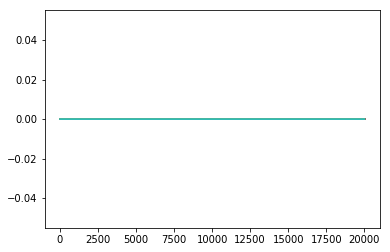

In [30]:
plt.plot(tf.squeeze(qz.params, 1).eval());

In [31]:
for i in range(hmc_steps):
    info_dict = inference.update()
    inference.print_progress(info_dict)

# inference.finalize()
# inference.run(variables=[], n_steps=hmc_steps)

20000/20000 [100%] ██████████████████████████████ Elapsed: 69s | Acceptance Rate: 0.015


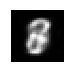

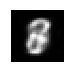

In [32]:
all_zeros = tf.Variable(tf.zeros([1, z_dim]))
sess.run(tf.variables_initializer([all_zeros]))
zeros_img, _ = P(all_zeros)
plot(zeros_img.eval())

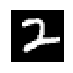

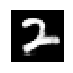

In [33]:
# inference.update()
keep_ratio = 0.2
to_keep_index = int((1-keep_ratio)*T)
qz_kept = Empirical(qz.params[to_keep_index:])

for element in range(inference_batch_size):
    z_test = qz_kept.sample(1)[:,element]
    img, _ = P(z_test)
    plot([x_gt[element]])
    plot(img.eval())

## Sample from Posterior and Reconstruct Image

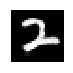

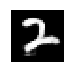

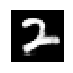

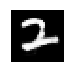

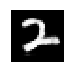

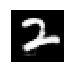

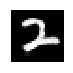

In [34]:
sample_to_vis = 5
qz_sample = qz_kept.sample(sample_to_vis)

for i in range(sample_to_vis):
    img, _ = P(qz_sample[i])
    plot(img.eval())
    
avg_img, _ = P(tf.reduce_mean(qz_sample, 0))
plot(avg_img.eval())

In [35]:
def l2_loss(x_gt,z_hmc):
    return tf.norm(x_gt-P(z_hmc)[0]).eval()

def recon_loss(x_gt,z_hmc): 
    return tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=P(z_hmc)[1], labels=x_gt), 1).eval()

In [36]:
num_to_best = 100

print recon_loss(x_gt,Q(x_gt)[0])
print l2_loss(x_gt,Q(x_gt)[0])
print "-----samples------"

samples_to_check = qz_kept.sample(num_to_best).eval()

best_sample = samples_to_check[0]

for sample in samples_to_check:
    
#     print recon_loss(x_gt,this_sample)
    if recon_loss(x_gt,sample)<recon_loss(x_gt,best_sample):
        best_sample = sample
        print 'yay'
    print recon_loss(x_gt,sample)
    print l2_loss(x_gt,sample)
    print "-------------"

[ 77.63661194]
2.90501
-----samples------
[ 74.44851685]
2.63861
-------------
yay
[ 70.53371429]
2.53702
-------------
[ 72.29724884]
2.58512
-------------
[ 70.85827637]
2.48058
-------------
[ 70.85827637]
2.48058
-------------
[ 74.39810944]
2.72077
-------------
yay
[ 67.70166016]
2.25873
-------------
[ 70.53371429]
2.53702
-------------
[ 81.92434692]
2.91068
-------------
[ 77.1995163]
2.85207
-------------
yay
[ 67.6769104]
2.31416
-------------
[ 72.64096832]
2.56609
-------------
[ 78.17019653]
2.81727
-------------
[ 69.5875473]
2.3517
-------------
[ 67.70166016]
2.25873
-------------
[ 69.97383118]
2.47163
-------------
[ 70.32315826]
2.43491
-------------
[ 74.39810944]
2.72077
-------------
[ 69.0663147]
2.33377
-------------
[ 70.21512604]
2.46892
-------------
[ 72.64096832]
2.56609
-------------
[ 76.6844101]
2.76188
-------------
[ 72.64096832]
2.56609
-------------
[ 68.75498962]
2.30033
-------------
[ 72.64096832]
2.56609
-------------
[ 78.17019653]
2.81727
----

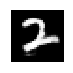

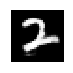

In [37]:
plot(P(best_sample)[0].eval())


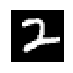

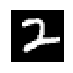

In [38]:
plot(x_gt)


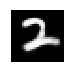

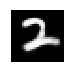

In [42]:
plot(P(Q(x_gt)[0])[0].eval())

In [41]:
best_sample.eval()

AttributeError: 'numpy.ndarray' object has no attribute 'eval'

In [43]:
stored = qz_kept.sample(4)[:].eval()

In [44]:
qz_kept.prob(Q(x_gt)[0])

NotImplementedError: prob is not implemented

In [45]:
Q(x_gt)[0]

<tf.Tensor 'encoder_14/add_1:0' shape=(1, 100) dtype=float32>

# Visualizing Latent Stuff

In [46]:
dims = [0,1]

# hmc
num_samples = 500
hmc_samples = qz.sample(num_samples).eval()[:,:,dims]
hmc_samples = hmc_samples.reshape(num_samples,2)

# vae
z_mu, z_logvar = Q(x_gt)
z_mu, z_logvar = z_mu.eval()[:,dims], z_logvar.eval()[:,dims]
z_sig = np.sqrt(np.exp(z_logvar))


import matplotlib.mlab as mlab

def z_pdf(x):
    return mlab.normpdf(x, z_mu, z_sig)

z_pdf([0,0])


array([[ 0.40365155,  0.06989891]])

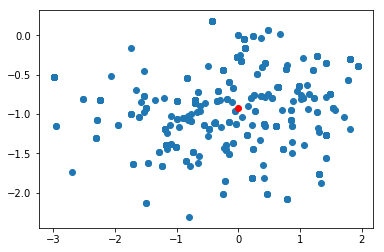

In [47]:
plt.scatter(hmc_samples[:,0],hmc_samples[:,1])

delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
# Z = 

plt.scatter(z_mu[:,0],z_mu[:,1],c='red')

In [48]:
print z_mu
print z

[[-0.01433733 -0.9179365 ]]
RandomVariable("Normal_3/", shape=(1, 100), dtype=float32)


In [49]:
example[:,:,dims]

NameError: name 'example' is not defined

In [50]:
hmc_samples.reshape(100,2)

ValueError: cannot reshape array of size 1000 into shape (100,2)

## Using PCA to visualize latent dimensions

In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
hmc_trans = pca.fit_transform(hmc_samples)

[[ 0.01857953  0.01106467]]


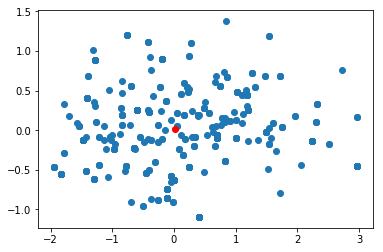

In [61]:
# Plot the HMC samples vs VAE samples
plt.scatter(hmc_trans[:,0],hmc_trans[:,1])
z_mu_transform = pca.transform(z_mu)
print z_mu_transform
plt.scatter(z_mu_transform[:,0],z_mu_transform[:,1],c='red')